<a href="https://colab.research.google.com/github/kimdain0222/kimdain0222/blob/main/hw_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from sklearn.datasets import fetch_openml

usps = fetch_openml(name='usps', version=1)
X,y =usps['data'], usps['target'].astype(int)
#주어진 데이터 불러오기

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:1030: UserWarning: Version 1 of dataset USPS is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://api.openml.org/data/v1/download/18805612/USPS.arff
  warn(


In [5]:
#필수 라이브러리
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedKFold # 각 클래스 분포 유지하며 4개는 학습,1개는 검증에 사용
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [6]:
# 1. 데이터 로드 및 전처리
usps = fetch_openml('usps', version=1)
X, y = usps['data'], usps['target'].astype(int)

# 레이블 재매핑: 1-10 → 0-9 why?원본 데이터 레이블과 모델 출력이 불일치 해서
y = y - 1  # 모든 레이블 값에서 1을 빼기
print(f"레이블 범위 확인: {np.min(y)} ~ {np.max(y)}")  # 0~9 확인

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 텐서 변환_ 텐서란 PyTorch에서 제공하는 다차원 배열로, GPU에서 연산을 수행할 수 있어 딥러닝 학습 시 속도 크게 향상
X = torch.tensor(X_scaled, dtype=torch.float32) #32비트는 모델 연산에 최적화
y = torch.tensor(y.values, dtype=torch.long)

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:1030: UserWarning: Version 1 of dataset USPS is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://api.openml.org/data/v1/download/18805612/USPS.arff
  warn(


레이블 범위 확인: 0 ~ 9


In [7]:
# 2. 신경망 모델 구조
class DigitClassifier(nn.Module): #nn.Module: PyTorch의 모든 신경망 모델의 기본 클래스
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential( #레고 블록처럼 층을 쌓는 컨테이너로 계층을 만둚(수동연결 불필요)
            nn.Linear(256, 128), #입력층(256차원 입력으로 128차원 추출)
            nn.ReLU(), #선형 변환만으로는 복잡한 패턴 학습 불가하기에 비선형성을 도입하여 기울기 소실 문제 완화
            nn.Linear(128, 64), #은닉층(특징을 압축하여 차원축)_ 입력(256) > 은닉1(128) > 은닉2(64) > 출력(10)
            nn.ReLU(), #크레이프 케익처럼 쌓아주기
            nn.Linear(64, 10)) #출력층(10은 0~9 숫자 클래스 개수를 뜻)=10개 숫자 점수
#모델구조: 입력(256) -> 선형(128) -> ReLU -> 선형(64) -> ReLU -> 선형(10) -> 출력(10)
    def forward(self, x): #forward: 모델의 핵심 함수 (반드시 구현)/x: 입력 데이터 (shape: [batch_size, 256])
        return self.layers(x)

In [8]:
# 3. 5겹 교차검증 설정 (5번 반복) 근데 어케 학습 4개, 1개 검증인데 5번을 반복할 수 있지?=모든 데이터가 한 번은 검증에 사용됨
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = [] #Fold의 최종 검증 정확도 저장
all_train_losses = [] #모든 Fold의 에포크별 학습 손실값 기록하여 학습 수렴 여부 확인
all_val_accs = [] #모든 Fold의 에포크별 검증 정확도 기록해서 과적합 발생 시점 파악


▶ Fold 1/5
Epoch 10/50 | Loss: 0.0169 | Acc: 0.9694
Epoch 20/50 | Loss: 0.0036 | Acc: 0.9790
Epoch 30/50 | Loss: 0.0025 | Acc: 0.9769
Epoch 40/50 | Loss: 0.0031 | Acc: 0.9710
Epoch 50/50 | Loss: 0.0032 | Acc: 0.9737

★ Fold 1 완료! 최종 정확도: 0.9737

▶ Fold 2/5
Epoch 10/50 | Loss: 0.0289 | Acc: 0.9634
Epoch 20/50 | Loss: 0.0186 | Acc: 0.9667
Epoch 30/50 | Loss: 0.0483 | Acc: 0.9624
Epoch 40/50 | Loss: 0.0015 | Acc: 0.9715
Epoch 50/50 | Loss: 0.0072 | Acc: 0.9758

★ Fold 2 완료! 최종 정확도: 0.9758

▶ Fold 3/5
Epoch 10/50 | Loss: 0.0153 | Acc: 0.9720
Epoch 20/50 | Loss: 0.0084 | Acc: 0.9688
Epoch 30/50 | Loss: 0.0583 | Acc: 0.9457
Epoch 40/50 | Loss: 0.0017 | Acc: 0.9742
Epoch 50/50 | Loss: 0.0052 | Acc: 0.9726

★ Fold 3 완료! 최종 정확도: 0.9726

▶ Fold 4/5
Epoch 10/50 | Loss: 0.0200 | Acc: 0.9607
Epoch 20/50 | Loss: 0.0091 | Acc: 0.9699
Epoch 30/50 | Loss: 0.0383 | Acc: 0.9489
Epoch 40/50 | Loss: 0.0009 | Acc: 0.9720
Epoch 50/50 | Loss: 0.0005 | Acc: 0.9693

★ Fold 4 완료! 최종 정확도: 0.9693

▶ Fold 5/5
Epoc

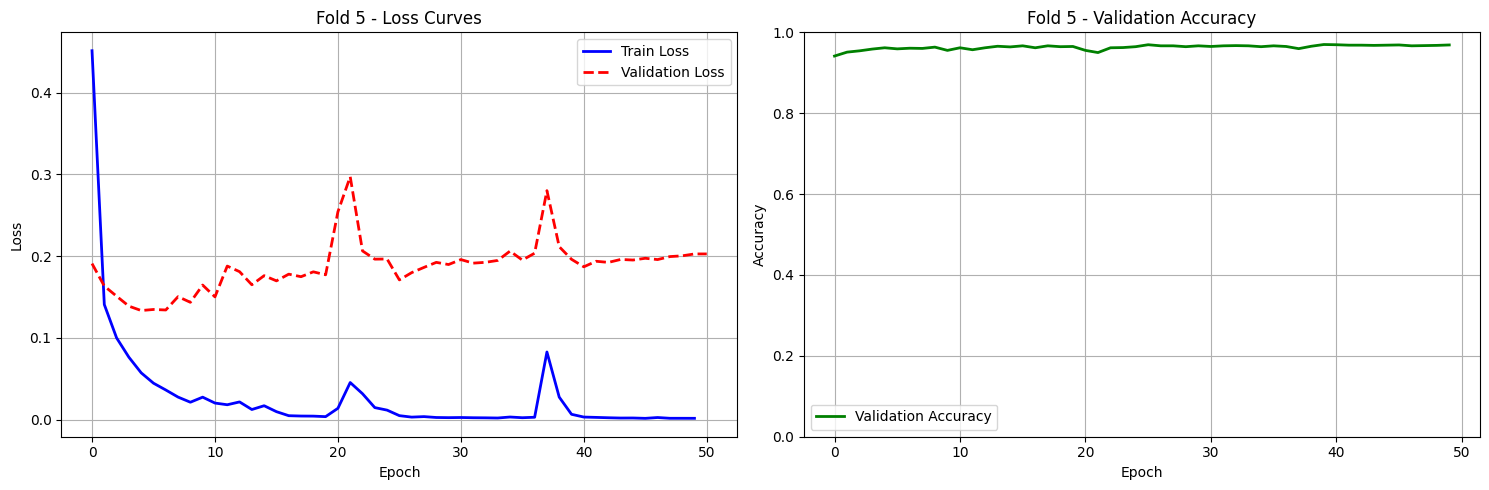

In [9]:
# 4. 교차검증 실행_ 교차검증을 하는 이유는 적은양의 데이터를 사용하면 신뢰도가 낮기에 여러번 하면서 정확도를 올리는 것임 약간 인생이 걸린 결정을 할때 여러번 검토하는 것과 같음
for fold, (train_idx , val_idx) in enumerate(kfold.split(X.cpu().numpy(), y.cpu().numpy())):
    print(f"\n{'='*40}")
    print(f"▶ Fold {fold+1}/5")
    print(f"{'='*40}")
#train_idx: 학습용 / val_idx: 검증용
#enumerate: 폴드 번호(0~4)와 인덱스 동시 추출

    # 데이터 분할
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # DataLoader 생성
    train_dataset = TensorDataset(X_train, y_train) #TensorDataset: 데이터-레이블 쌍 생성
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32) #64나 32 상관 ㄴ

    # 모델 초기화
    model = DigitClassifier()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #Adam: 학습률 0.001의 최적화
    criterion = nn.CrossEntropyLoss() #CrossEntropyLoss: 다중 분류 손실 함수

    # 학습 상태 추적
    fold_train_losses = [] #현재 폴드의 학습 손실 기록용
    fold_val_losses = []  # 검증 손실 저장용 리스트 추가
    fold_val_accs = [] #현재 폴드의 검증 정확도 기록용

    # 학습 루프
    for epoch in range(50):
        # 학습 단계
        model.train()
        epoch_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad() #zero_grad(): 이전 기울기 초기화
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() #loss.backward(): 기울기 계산 (역전파)
            optimizer.step() #optimizer.step(): 가중치 업데이트
            epoch_loss += loss.item() #epoch_loss: 배치 손실 누적

        # 검증 단계
        model.eval() #검증 모드로 전환하겠다
        val_loss = 0.0  # 검증 손실 초기화
        correct = 0
        total = 0

        with torch.no_grad(): #기울기 계산 비활성화하겠 (메모리 절약)
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # 손실 계산
                val_loss += loss.item() * inputs.size(0)  # 배치 크기 고려
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        # 성능 계산
        avg_loss = epoch_loss / len(train_loader) #평균 손실: 총 손실 / 배치 수
        avg_val_loss = val_loss / total  # 검증 손실 평균
        val_acc = correct / total #정확도: 정답 수 / 전체 검증 샘플 수



        # 에포크 기록 저장
        fold_train_losses.append(avg_loss)
        fold_val_losses.append(avg_val_loss)  # 검증 손실 저장
        fold_val_accs.append(val_acc)

        # 10 에포크마다 손실,정확도 출력- 학습 진행상황 모니터링
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/50 | Loss: {avg_loss:.4f} | Acc: {val_acc:.4f}")

    # 폴드 결과 저장
    final_acc = fold_val_accs[-1] #최종 정확도: 마지막 에포크의 검증 정확도
    accuracies.append(final_acc) #accuracies: 5개 폴드의 최종 정확도 저장
    all_train_losses.append(fold_train_losses) #all_train_losses: 모든 폴드의 손실 기록 저장
    all_val_accs.append(fold_val_accs) #all_val_accs: 모든 폴드의 정확도 기록 저장

    print(f"\n★ Fold {fold+1} 완료! 최종 정확도: {final_acc:.4f}")


#--------------------------------------------------------------------------------
    #if) 검증 손실이 증가 → 과적합 발생 (모델 복잡도 ↓, 드롭아웃 ↑)
    #if) 훈련 손실이 높게 유지 → 과소적합 (모델 복잡도 ↑, 학습률 조정)
    # === 수정된 학습 곡선 시각화 부분 ===
plt.figure(figsize=(15, 5))

# 손실 곡선 (훈련 손실 + 검증 손실)
plt.subplot(1, 2, 1)


# 훈련 손실과 검증 손실을 한 그래프에 플롯
plt.plot(fold_train_losses, 'b-', label='Train Loss', linewidth=2) #파란색 실선: 훈련 손실
plt.plot(fold_val_losses, 'r--', label='Validation Loss', linewidth=2) #빨간색 점선: 검증 손실
plt.title(f"Fold {fold+1} - Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 2. 정확도 곡선 (검증 정확도)
plt.subplot(1, 2, 2)
plt.plot(fold_val_accs, 'g-', label='Validation Accuracy', linewidth=2)
plt.title(f"Fold {fold+1} - Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)  # 정확도 범위 설정 (0~100%)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
#<전체 흐름 요약>
#5겹 분할 → 2. 데이터 준비 → 3. 모델 초기화

#50회 에포크 실행 (학습 → 검증) → 5. 결과 기록

#폴드 완료 시 곡선 시각화 → 7. 다음 폴드로 이동

#so, 이 과정을 5번 반복하여 모든 데이터가 한 번씩 검증되도록 함
#"5개의 독립적 실험"을 수행하는 것과 같음

#이미지 인식, 시계열 예측, 적은 데이터, 불균형 데이터에 사용됨

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:1030: UserWarning: Version 1 of dataset USPS is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://api.openml.org/data/v1/download/18805612/USPS.arff
  warn(



▶ Fold 1/5
Epoch 01 | Train Loss: 0.4671 | Val Loss: 0.1902 | Val Acc: 0.9495
Epoch 02 | Train Loss: 0.1521 | Val Loss: 0.1561 | Val Acc: 0.9586
Epoch 03 | Train Loss: 0.1100 | Val Loss: 0.1467 | Val Acc: 0.9661
Epoch 04 | Train Loss: 0.0829 | Val Loss: 0.1495 | Val Acc: 0.9672
Epoch 05 | Train Loss: 0.0595 | Val Loss: 0.1315 | Val Acc: 0.9715


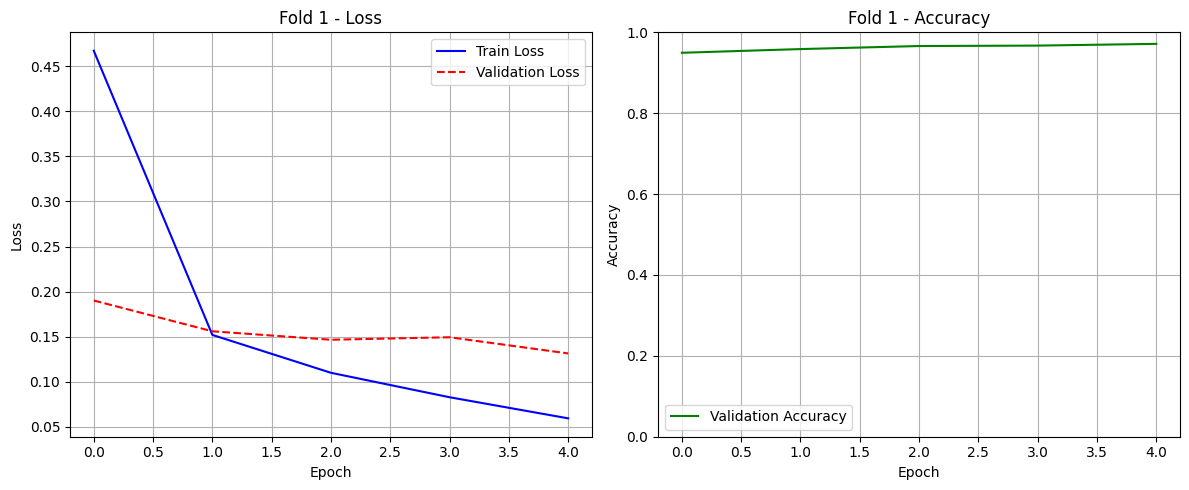


▶ Fold 2/5
Epoch 01 | Train Loss: 0.4577 | Val Loss: 0.2007 | Val Acc: 0.9430
Epoch 02 | Train Loss: 0.1495 | Val Loss: 0.1518 | Val Acc: 0.9570
Epoch 03 | Train Loss: 0.1053 | Val Loss: 0.1491 | Val Acc: 0.9575
Epoch 04 | Train Loss: 0.0780 | Val Loss: 0.1301 | Val Acc: 0.9575
Epoch 05 | Train Loss: 0.0569 | Val Loss: 0.1371 | Val Acc: 0.9629


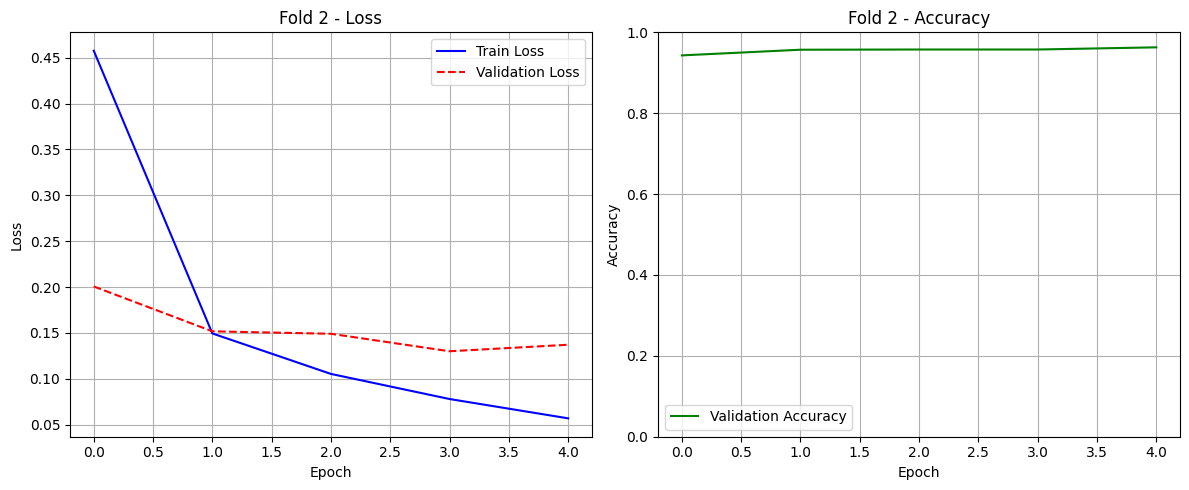


▶ Fold 3/5
Epoch 01 | Train Loss: 0.4682 | Val Loss: 0.1755 | Val Acc: 0.9500
Epoch 02 | Train Loss: 0.1454 | Val Loss: 0.1463 | Val Acc: 0.9618
Epoch 03 | Train Loss: 0.1023 | Val Loss: 0.1439 | Val Acc: 0.9602
Epoch 04 | Train Loss: 0.0812 | Val Loss: 0.1560 | Val Acc: 0.9538
Epoch 05 | Train Loss: 0.0616 | Val Loss: 0.1182 | Val Acc: 0.9656


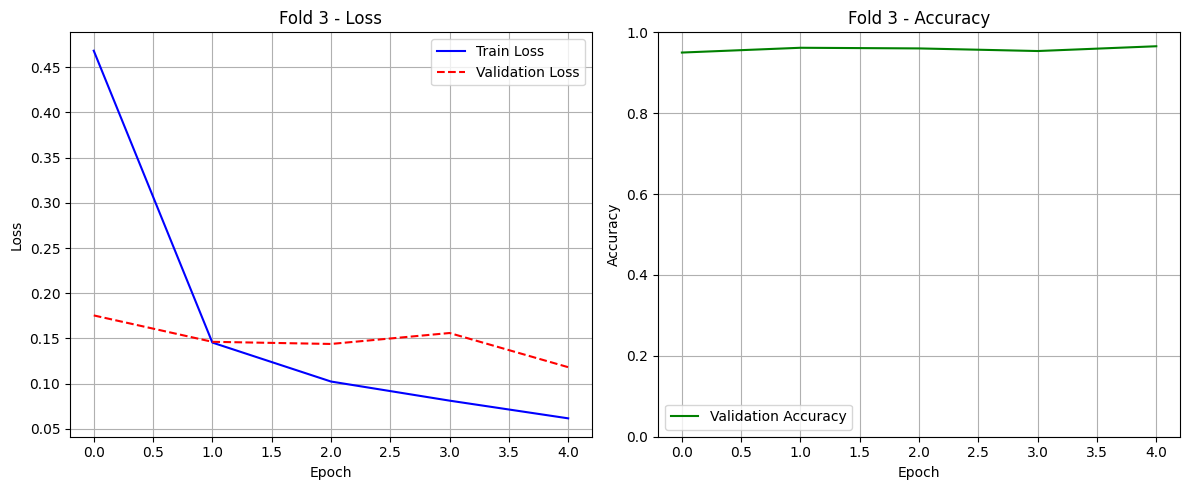


▶ Fold 4/5
Epoch 01 | Train Loss: 0.4658 | Val Loss: 0.2090 | Val Acc: 0.9408
Epoch 02 | Train Loss: 0.1485 | Val Loss: 0.1868 | Val Acc: 0.9505
Epoch 03 | Train Loss: 0.1022 | Val Loss: 0.1659 | Val Acc: 0.9586
Epoch 04 | Train Loss: 0.0742 | Val Loss: 0.1565 | Val Acc: 0.9634
Epoch 05 | Train Loss: 0.0600 | Val Loss: 0.1564 | Val Acc: 0.9650


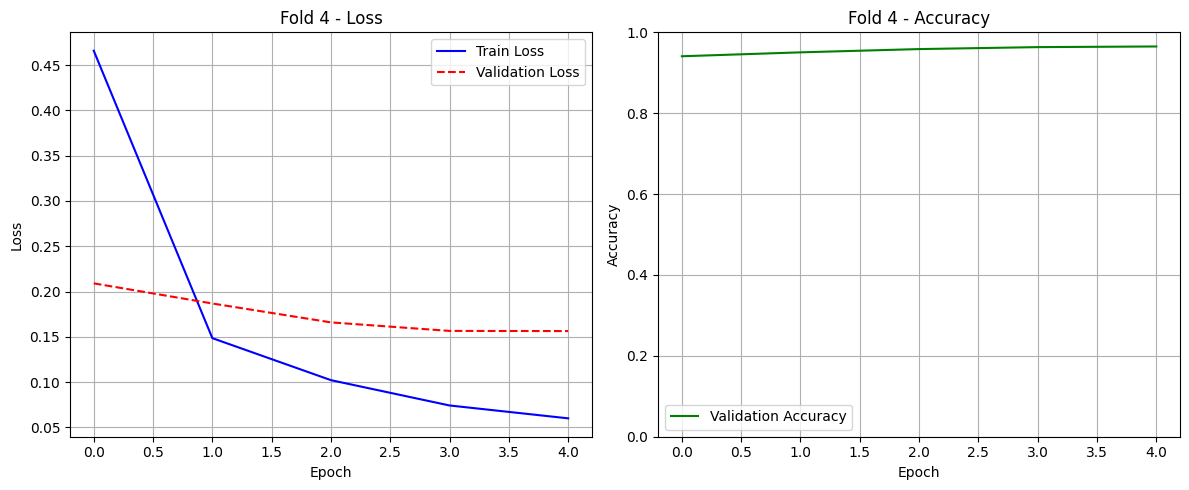


▶ Fold 5/5
Epoch 01 | Train Loss: 0.4541 | Val Loss: 0.1879 | Val Acc: 0.9457
Epoch 02 | Train Loss: 0.1466 | Val Loss: 0.1564 | Val Acc: 0.9516
Epoch 03 | Train Loss: 0.1047 | Val Loss: 0.1401 | Val Acc: 0.9559
Epoch 04 | Train Loss: 0.0743 | Val Loss: 0.1740 | Val Acc: 0.9408
Epoch 05 | Train Loss: 0.0598 | Val Loss: 0.1421 | Val Acc: 0.9586


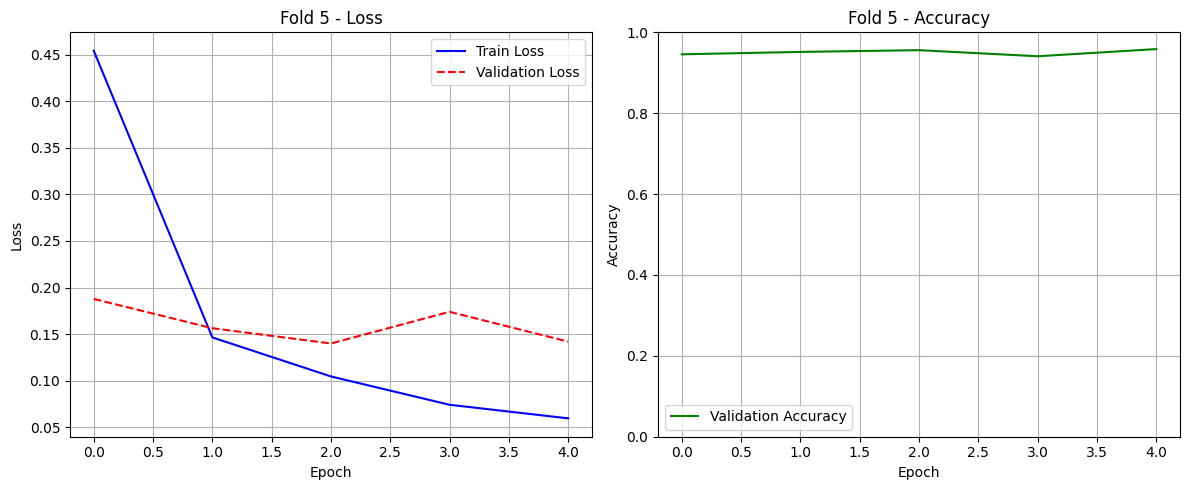

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
usps = fetch_openml('usps', version=1)
X, y = usps['data'], usps['target'].astype(int)
y = y - 1  # 1~10 → 0~9로 재매핑

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)

# 2. 신경망 모델 정의
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.layers(x)

# 3. 5-Fold 교차검증
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\n{'='*40}\n▶ Fold {fold+1}/5\n{'='*40}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

    model = DigitClassifier()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(5):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 검증
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # 시각화
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Train Loss')
    plt.plot(val_losses, 'r--', label='Validation Loss')
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, 'g-', label='Validation Accuracy')
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
